In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
root = '/gdrive/My Drive/en/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
!pip install suntime
from suntime import Sun
import pytz

In [3]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Solar funcs

In [31]:
# Ankara's Coordinates
lon = 33.029
phi = 40.239

delta_GMT = 3
gamma = 0
beta=45

def calc_glob_irrad(N,time,lon=lon, delta_GMT=delta_GMT, phi=phi):
    gamma = 0
    beta=45
    omega = calc_omega(N, lon, delta_GMT, time)
    delta = calc_delta(N)
    alpha_s = calc_alpha_s(phi, delta, omega)
    if (alpha_s>0).bool():
        gamma_s = calc_gamma_s(alpha_s, phi, delta, omega)
        cos_theta_i = calc_cos_theta_i(alpha_s, gamma_s, gamma, beta)
        if cos_theta_i>0:
            G_on = calc_G_on(N)
            G_beam = calc_direct_irrad(G_on, alpha_s, cos_theta_i, T_L=2)
            T_rd = calc_t_rd(T_L=2)
            G_d = calc_diffuse_irrad(T_rd, alpha_s, G_on, beta)
            G_glob = G_beam + G_d
        else:
            G_glob = 0
    else:
        G_glob = 0
    return G_glob

def calc_omega(N, lon, delta_GMT, time):
    sol_time = calc_sol_time(N, lon, delta_GMT, time)
    omega = 15 * (sol_time-12)
    return omega

def calc_sol_time(N, lon, delta_GMT, time):
    sol_time_minus_st_time = calc_sol_time_minus_st_time(N, lon, delta_GMT)
    sol_time = time+sol_time_minus_st_time
    return(sol_time)

def calc_sol_time_minus_st_time(N, lon, delta_GMT): # TEST PASSED!
    E = calc_eot(N)
    sol_time_minus_st_time = (4 * (lon-15*delta_GMT)+E)/60
    return sol_time_minus_st_time

def calc_delta(N):
    delta = 23.45 * np.sin(360*(284+N)*np.pi/180/365)
    return delta

def calc_alpha_s(phi, delta, omega):
    part1 = np.sin(phi*np.pi/180) * np.sin(delta*np.pi/180)
    part2 = np.cos(phi*np.pi/180) * np.cos(delta*np.pi/180) * np.cos(omega*np.pi/180)
    in_arcsin = part1 + part2
    alpha_s = (np.arcsin(in_arcsin)*180)/np.pi #converting rad->deg
    return alpha_s

def calc_gamma_s(alpha_s, phi, delta, omega):
    top = np.sin(alpha_s*np.pi/180) * np.sin(phi*np.pi/180) - np.sin(delta*np.pi/180)
    bot = np.cos(alpha_s*np.pi/180) * np.cos(delta*np.pi/180)
    in_arccos = top / bot # this is in rad
    in_abs = np.arccos(in_arccos) * 180/np.pi #this is in degrees
    gamma_s = np.sign(omega) * np.absolute(in_abs)
    return gamma_s

def calc_cos_theta_i(alpha_s, gamma_s, beta=45, gamma=0):
    part1 = np.sin(alpha_s*np.pi/180) * np.cos(beta*np.pi/180)
    d_gamma = gamma_s-gamma
    part2 = np.cos(alpha_s*np.pi/180) * np.sin(beta*np.pi/180) * np.cos(d_gamma*np.pi/180)
    cos_theta_i =  part1 + part2 #this is in radian
    return cos_theta_i

def calc_G_on(N):
    G_on = 1367 * (1 + 0.033 * np.cos(360*N/365*np.pi/180))
    return G_on

def calc_direct_irrad(G_on, alpha_s, cos_theta_i, T_L=2):
    m = calc_m(alpha_s)
    d_R = calc_d_R(m)
    in_exp = -0.8662 * T_L * m * d_R
    G_beam = G_on * cos_theta_i * np.exp(in_exp)
    return G_beam


def calc_m(alpha_s, z=-53):
    z_h = 8434.5
    pp0 = np.exp(-z/z_h)
    alpha_s_true = calc_alpha_s_true(alpha_s)
    bot = np.sin(alpha_s_true*np.pi/180) + 0.50572 * ((alpha_s_true + 6.07995)**(-1.6364))
    m = pp0/bot
    return m


def calc_d_R(m):
    if m<=20:
        bot = 6.6296 + 1.7514*m - 0.1202*(m**2) + 0.0065*(m**3) - 0.00013*(m**4)
    else:
        bot = 10.4 + 0.718*m
    d_R = 1 / bot
    return d_R


def calc_alpha_s_true(alpha_s):
    d_alpha_ref = calc_d_alpha_ref(alpha_s)
    alpha_s_true = alpha_s + d_alpha_ref
    return alpha_s_true

def calc_d_alpha_ref(alpha_s):
    part1 = 0.061359 * (180/np.pi)
    top2 = 0.1594 + 1.123*(np.pi/180)*alpha_s + 0.065656*((np.pi/180)**2)*(alpha_s**2)
    bot3  = 1 + 28.9344*(np.pi/180)*alpha_s + 277.3971*((np.pi/180)**2)*(alpha_s**2)
    d_alpha_ref = part1 * (top2 / bot3)
    return d_alpha_ref

def calc_t_rd(T_L=2):
    T_rd = -0.015843 + 0.030543*T_L + 0.0003797*(T_L**2)
    return T_rd

def calc_diffuse_irrad(T_rd, alpha_s, G_on, beta):
    F_d = calc_f_d(T_rd, alpha_s, T_L=2)
    G_d = G_on * T_rd * F_d * ((1+np.cos(beta*np.pi/180))/2)
    return G_d

def calc_f_d(T_rd, alpha_s, T_L=2):
    A0 = 0.26463 - 0.061581*T_L + 0.0031408*(T_L**2)
    if (A0*T_rd <0.002):
        A0 = 0.002/T_rd
    A1 = 2.0402 + 0.018945*T_L - 0.011161*(T_L**2)
    A2 = 1.3025 + 0.039231*T_L + 0.0085079*(T_L**2)
    F_d = A0 + A1*np.sin(alpha_s*np.pi/180) + A2*(np.sin(alpha_s*np.pi/180)**2)
    return F_d


def calc_sun_azimuth_for_df(N, time, lon=lon, delta_GMT=delta_GMT, phi=phi):
    delta = calc_delta(N)
    omega = calc_omega(N, lon, delta_GMT, time)
    alpha_s = calc_alpha_s(phi, delta, omega)
    gamma_s = calc_gamma_s(alpha_s, phi, delta, omega)
    return gamma_s

def calc_sol_time(N, lon, delta_GMT, time):
    sol_time_minus_st_time = calc_sol_time_minus_st_time(N, lon, delta_GMT)
    sol_time = time+sol_time_minus_st_time
    return(sol_time)


def calc_sol_time_minus_st_time(N, lon, delta_GMT): # TEST PASSED!
    E = calc_eot(N)
    sol_time_minus_st_time = (4 * (lon-15*delta_GMT)+E)/60
    return sol_time_minus_st_time


def calc_eot(N):
    B = (N-1) * 360/365
    E = 229.2*(0.000075 + 0.001868*np.cos(B*np.pi/180) - 0.032077*np.sin(B*np.pi/180) - 0.014615*np.cos(2*B*np.pi/180) - 0.04089*np.sin(2*B*np.pi/180))
    return E


# 1.Data

In [5]:
generation = pd.read_csv(root+"generation.csv", sep=";", decimal=",")

In [6]:
generation = generation.dropna(how='all')
generation

,DateTime,Generation
0,01Jan2019 0:00:00,0.000000
1,01Jan2019 1:00:00,0.000000
2,01Jan2019 2:00:00,0.000008
3,01Jan2019 3:00:00,0.000000
4,01Jan2019 4:00:00,0.000008
...,...,...
25555,30Nov2021 19:00:00,0.000000
25556,30Nov2021 20:00:00,0.000000
25557,30Nov2021 21:00:00,0.000000
25558,30Nov2021 22:00:00,0.000000


In [7]:
temperature = pd.read_csv(root+"temperature.csv", sep=";", decimal=",")

In [8]:
temperature = temperature.dropna(how='all')
temperature['WWCode'] = temperature['WWCode'].replace(84, 83)
temperature['DateTime'] = pd.to_datetime(temperature['DateTime'])

In [9]:
df = temperature

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 0 to 26303
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             26304 non-null  datetime64[ns]
 1   AirTemperature       26304 non-null  float64       
 2   ComfortTemperature   26304 non-null  float64       
 3   RelativeHumidity     26304 non-null  float64       
 4   WindSpeed            26304 non-null  float64       
 5   WindDirection        26304 non-null  float64       
 6   WWCode               20050 non-null  float64       
 7   EffectiveCloudCover  26304 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.8 MB


In [11]:
df.nunique()

DateTime               26304
AirTemperature           494
ComfortTemperature       502
RelativeHumidity         849
WindSpeed                 78
WindDirection            267
WWCode                    53
EffectiveCloudCover       78
dtype: int64

# 2.Data Cleaning

## 2.1 Missing Values

In [12]:
df.isnull().sum()*100/df.shape[0]

DateTime                0.000000
AirTemperature          0.000000
ComfortTemperature      0.000000
RelativeHumidity        0.000000
WindSpeed               0.000000
WindDirection           0.000000
WWCode                 23.775852
EffectiveCloudCover     0.000000
dtype: float64

In [13]:
df.WWCode.value_counts()

0.0     6294
2.0     2206
3.0     1646
5.0     1432
1.0     1226
10.0    1207
4.0     1147
80.0     969
25.0     895
6.0      748
60.0     404
95.0     331
7.0      212
70.0     203
71.0     155
21.0     120
29.0      97
61.0      91
22.0      91
26.0      76
45.0      70
51.0      66
17.0      46
68.0      43
81.0      31
85.0      30
50.0      28
23.0      26
73.0      20
77.0      20
83.0      20
41.0      12
40.0       9
27.0       9
42.0       8
46.0       6
48.0       6
13.0       6
91.0       6
86.0       5
8.0        5
44.0       5
47.0       4
96.0       3
62.0       3
20.0       3
28.0       3
43.0       2
72.0       1
82.0       1
99.0       1
87.0       1
63.0       1
Name: WWCode, dtype: int64

In [14]:
df["WWCode"] = df["WWCode"].replace(np.nan, df.WWCode.mode()[0])

## 2.2 Outlier

Özellik data setinde outlier bulunmuyor.

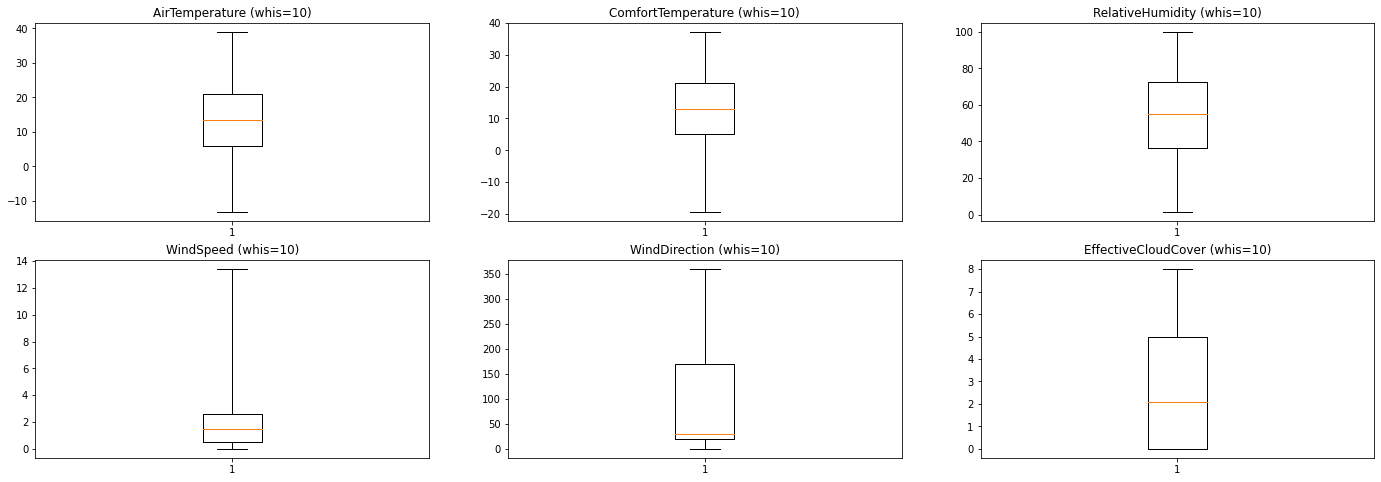

In [15]:
plt.figure(figsize=(24,8))
count = 0
for i in ["AirTemperature","ComfortTemperature",
          "RelativeHumidity", "WindSpeed",
          "WindDirection", "EffectiveCloudCover"]:
  count+=1
  plt.subplot(2,3,count)
  plt.boxplot(df[i], whis=10)
  plt.title(f"{i} (whis=10)")

plt.show()

Targer valueda outlier bulunmuyor.

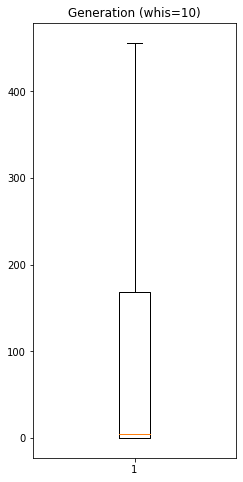

In [16]:
plt.figure(figsize=(8,8))
count = 0
for i in ["Generation"]:
  count+=1
  plt.subplot(1,2,count)
  plt.boxplot(generation[i], whis=10)
  plt.title(f"{i} (whis=10)")

plt.show()

# 3.Data Exploration

## 3.1.One Variable Analysis

In [17]:
df.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
count,26304,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
unique,26304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,13.741522,13.239397,54.352832,1.655931,87.463960,9.982056,2.614051
std,NaN,9.379876,9.767058,22.566688,1.353196,100.762932,22.080193,2.497609
min,NaN,-13.100000,-19.300000,1.600000,0.000000,0.000000,0.000000,0.000000
25%,NaN,6.000000,5.100000,36.600000,0.500000,20.000000,0.000000,0.000000


### 3.1.1 Continouos Variable Analysis

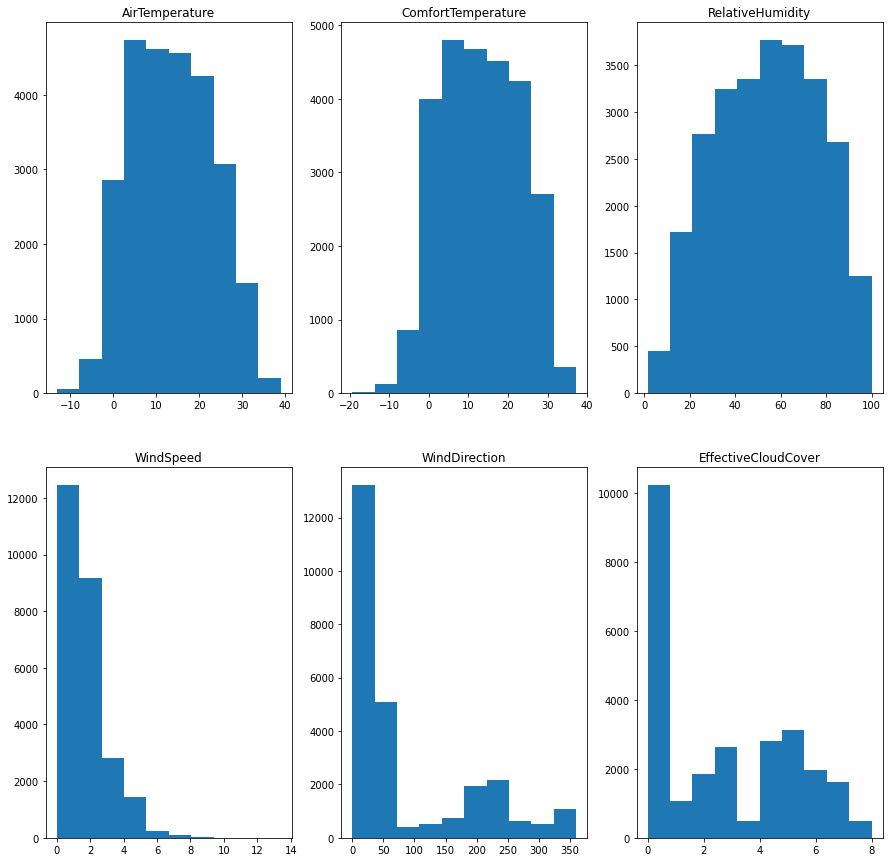

In [18]:
plt.figure(figsize=(15,15))

degiskenler = ["AirTemperature","ComfortTemperature",
          "RelativeHumidity", "WindSpeed",
          "WindDirection", "EffectiveCloudCover"]

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(df[degiskenler[i]])
    plt.title(degiskenler[i])

In [19]:
df["WindDirection_sqrt"] = np.sqrt(df["WindDirection"])
df["WindSpeed_sqrt"] = np.sqrt(df["WindSpeed"])
df["EffectiveCloudCover_sqrt"] = np.sqrt(df["EffectiveCloudCover"])

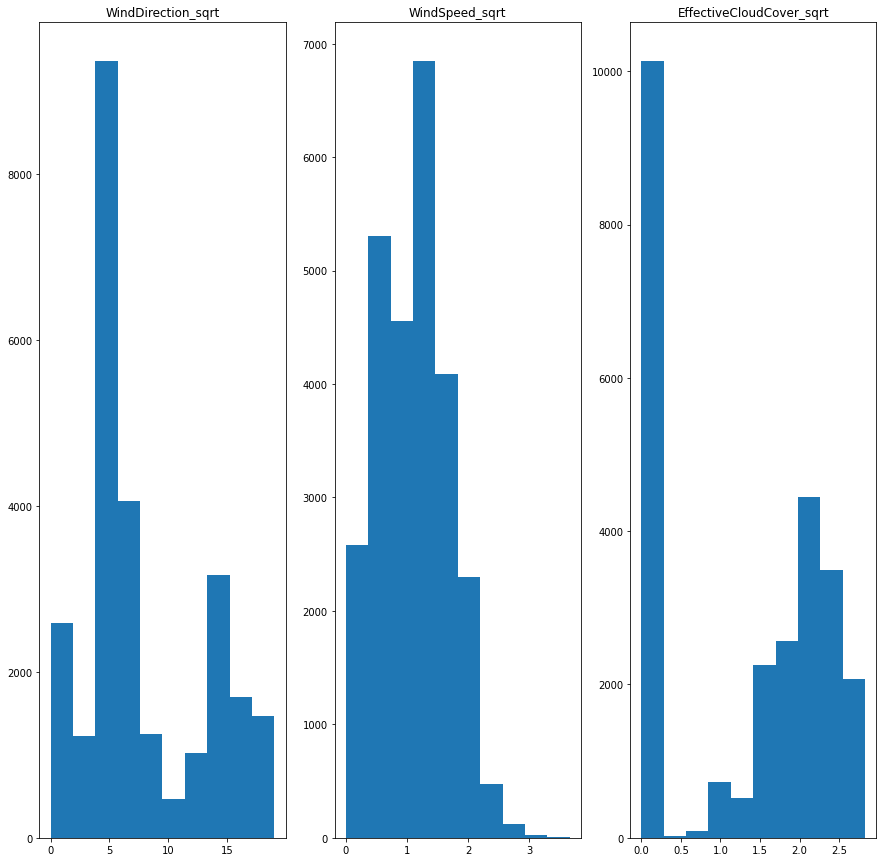

In [20]:
plt.figure(figsize=(15,15))

degiskenler_log = ["WindDirection_sqrt","WindSpeed_sqrt",
          "EffectiveCloudCover_sqrt"]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(df[degiskenler_log[i]])
    plt.title(degiskenler_log[i])

### 3.1.2 Categorical Variable Visualization

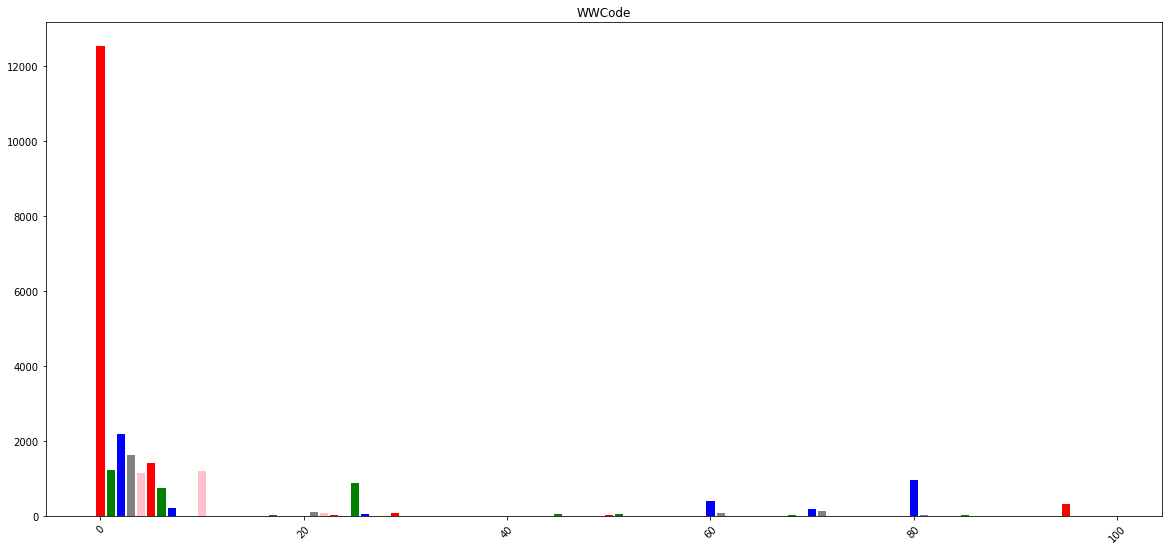

In [21]:
plt.figure(figsize=(20,20))
categorical_variables = ["WWCode"]
for i in range(1):
  plt.subplot(2, 1, i+1)
  plt.bar(df.groupby(categorical_variables[i])[categorical_variables[i]].count().index, 
      df.groupby(categorical_variables[i])[categorical_variables[i]].count(), 
      color=["red","green","blue","grey","pink"])
  plt.title(categorical_variables[i])
  plt.xticks(rotation=45)

## 3.2.Multi Variable Analysis


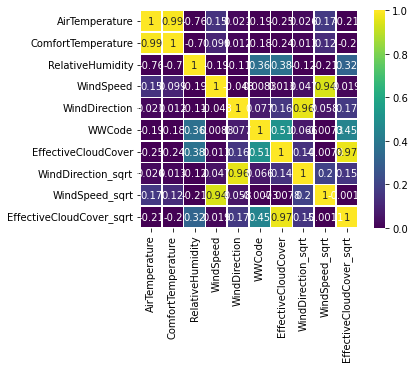

In [22]:
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.5, vmin=0, vmax=1, cmap='viridis')

In [23]:
df["Time"] = df.DateTime.apply(lambda x: x.hour)
df["Month"] = df.DateTime.apply(lambda x: x.month)
df["quarter"] = df.DateTime.apply(lambda x: x.quarter)
df["year"] = df.DateTime.apply(lambda x: x.year)
df["dayofyear"] = df.DateTime.apply(lambda x: x.dayofyear)
df["weekofyear"] = df.DateTime.apply(lambda x: x.weekofyear)
df["Date"] = df["DateTime"].apply(pd.to_datetime).dt.date.apply(str)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


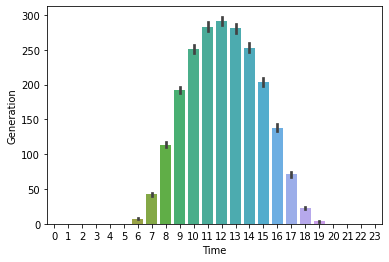

In [24]:
sns.barplot(df["Time"], generation["Generation"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


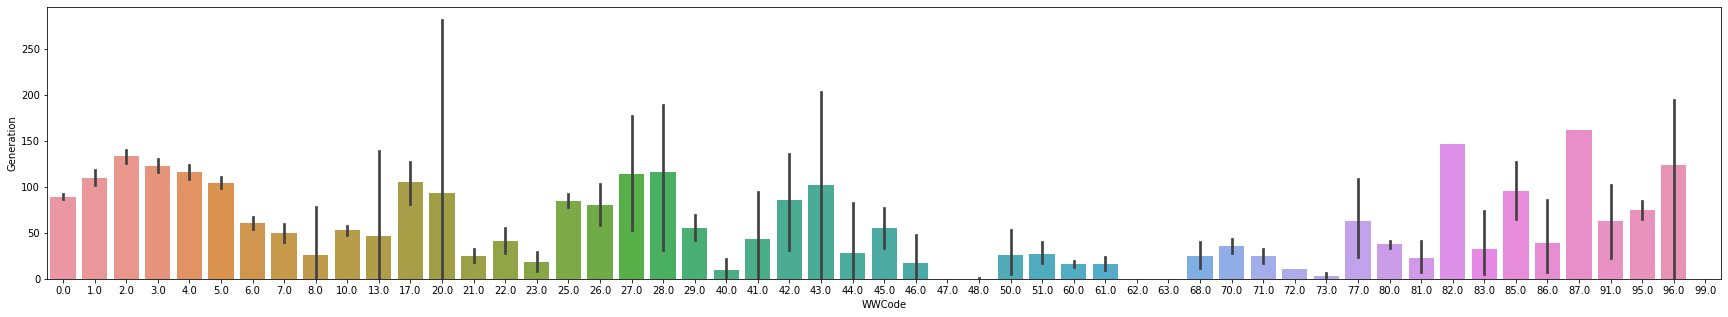

In [25]:
plt.figure(figsize=(30,5))
sns.barplot(df["WWCode"], generation["Generation"])

# 4.Feature Engineering

In [26]:
df.head()

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,WindDirection_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,Time,Month,quarter,year,dayofyear,weekofyear,Date
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,7.745967,1.897367,2.509980,0,1,1,2019,1,1,2019-01-01
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,8.366600,1.612452,2.121320,1,1,1,2019,1,1,2019-01-01
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,8.944272,1.760682,2.345208,2,1,1,2019,1,1,2019-01-01
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,7.745967,1.760682,2.756810,3,1,1,2019,1,1,2019-01-01
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,7.745967,2.144761,2.549510,4,1,1,2019,1,1,2019-01-01


In [27]:
coordinates = [40.239, 33.029] # Ankara

sun = Sun(coordinates[0], coordinates[1])
tz =pytz.timezone('Europe/Istanbul')
df["DayLight"]= df[["Date","Time"]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x["Date"]).date(),local_time_zone=tz).hour <= x["Time"] <= sun.get_local_sunset_time(pd.to_datetime(x["Date"]).date(),local_time_zone=tz).hour ,axis=1)

In [28]:
col_del = ["DateTime", "WindSpeed", "WindDirection", "EffectiveCloudCover"]
features_df=df.drop(columns=col_del,axis=1)
features_df.head()

,AirTemperature,ComfortTemperature,RelativeHumidity,WWCode,WindDirection_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,Time,Month,quarter,year,dayofyear,weekofyear,Date,DayLight
0,-1.7,-6.1,75.3,10.0,7.745967,1.897367,2.509980,0,1,1,2019,1,1,2019-01-01,False
1,-1.8,-5.3,75.3,10.0,8.366600,1.612452,2.121320,1,1,1,2019,1,1,2019-01-01,False
2,-2.0,-6.0,74.7,10.0,8.944272,1.760682,2.345208,2,1,1,2019,1,1,2019-01-01,False
3,-1.9,-5.9,76.4,10.0,7.745967,1.760682,2.756810,3,1,1,2019,1,1,2019-01-01,False
4,-2.0,-7.1,76.4,10.0,7.745967,2.144761,2.549510,4,1,1,2019,1,1,2019-01-01,False


In [32]:
#features_df['Azimuth'] = features_df.apply(lambda x: calc_sun_azimuth_for_df(N=features_df['dayofyear'],time=features_df['Time']),axis=1)
features_df['SolarRad'] = features_df.apply(lambda x: calc_glob_irrad(N=features_df['dayofyear'],time=features_df['Time']),axis=1)

ValueError: ignored

## Standard Scaling

In [28]:
numerical_columns = ["Azimuth", "SolarRad", "AirTemperature", "ComfortTemperature", "RelativeHumidity",
                     "WindSpeed_sqrt", "EffectiveCloudCover_sqrt",
                     "WindDirection_sqrt"]
sc = StandardScaler()
for i in range(8):
  features_df[numerical_columns[i]] = sc.fit_transform(features_df[[numerical_columns[i]]])

In [29]:
features_df = features_df.drop(["Date","dayofyear"], axis=1)

## Lag and Lead

In [30]:
a = pd.concat([features_df["AirTemperature"].shift(2).rename("AirTemperature_1"),
               features_df["AirTemperature"].shift(1).rename("AirTemperature_2"),
               features_df["AirTemperature"].shift(-1).rename("AirTemperature_3"),
               features_df["AirTemperature"].shift(-2).rename("AirTemperature_4")], axis=1)

b = pd.concat([features_df["RelativeHumidity"].shift(2).rename("RelativeHumidity_1"),
               features_df["RelativeHumidity"].shift(1).rename("RelativeHumidity_2"),
               features_df["RelativeHumidity"].shift(-1).rename("RelativeHumidity_3"),
               features_df["RelativeHumidity"].shift(-2).rename("RelativeHumidity_4")], axis=1)

c = pd.concat([features_df["WindSpeed_sqrt"].shift(2).rename("WindSpeed_sqrt_1"),
               features_df["WindSpeed_sqrt"].shift(1).rename("WindSpeed_sqrt_2"),
               features_df["WindSpeed_sqrt"].shift(-1).rename("WindSpeed_sqrt_3"),
               features_df["WindSpeed_sqrt"].shift(-2).rename("WindSpeed_sqrt_4")], axis=1)

d = pd.concat([features_df["EffectiveCloudCover_sqrt"].shift(2).rename("EffectiveCloudCover_sqrt_1"),
               features_df["EffectiveCloudCover_sqrt"].shift(1).rename("EffectiveCloudCover_sqrt_2"),
               features_df["EffectiveCloudCover_sqrt"].shift(-1).rename("EffectiveCloudCover_sqrt_3"),
               features_df["EffectiveCloudCover_sqrt"].shift(-2).rename("EffectiveCloudCover_sqrt_4")], axis=1)

e = pd.concat([features_df["Azimuth"].shift(2).rename("Azimuth_1"),
               features_df["Azimuth"].shift(1).rename("Azimuth_2"),
               features_df["Azimuth"].shift(-1).rename("Azimuth_3"),
               features_df["Azimuth"].shift(-2).rename("Azimuth_4")], axis=1)

f = pd.concat([features_df["SolarRad"].shift(2).rename("SolarRad_1"),
               features_df["SolarRad"].shift(1).rename("SolarRad_2"),
               features_df["SolarRad"].shift(-1).rename("SolarRad_3"),
               features_df["SolarRad"].shift(-2).rename("SolarRad_4")], axis=1)

In [31]:
features_df = pd.concat([features_df, pd.concat([a, b, c, d, e, f], axis=1)], axis=1)

In [33]:
features_df = features_df.ffill().bfill()

In [32]:
features_df.tail()

,AirTemperature,ComfortTemperature,RelativeHumidity,WWCode,WindDirection_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,Time,Month,quarter,year,dayofyear,weekofyear,DayLight,AirTemperature_1,AirTemperature_2,AirTemperature_3,AirTemperature_4,RelativeHumidity_1,RelativeHumidity_2,RelativeHumidity_3,RelativeHumidity_4,WindSpeed_sqrt_1,WindSpeed_sqrt_2,WindSpeed_sqrt_3,WindSpeed_sqrt_4,EffectiveCloudCover_sqrt_1,EffectiveCloudCover_sqrt_2,EffectiveCloudCover_sqrt_3,EffectiveCloudCover_sqrt_4
26299,-0.516170,-0.495491,0.338876,2.0,-1.493383,-1.998442,-0.009256,19,12,4,2021,365,52,False,-0.292283,-0.377573,-0.612122,-0.686752,-0.294813,0.072993,0.511701,0.697819,-0.770499,-1.998442,-1.998442,-1.998442,-0.009256,-0.009256,-0.009256,-0.009256
26300,-0.612122,-0.577400,0.511701,2.0,-1.493383,-1.998442,-0.009256,20,12,4,2021,365,52,False,-0.377573,-0.516170,-0.686752,-0.804026,0.072993,0.338876,0.697819,0.914957,-1.998442,-1.998442,-1.998442,-1.998442,-0.009256,-0.009256,-0.009256,0.172198
26301,-0.686752,-0.649071,0.697819,6.0,-1.493383,-1.998442,-0.009256,21,12,4,2021,365,52,False,-0.516170,-0.612122,-0.804026,-0.889317,0.338876,0.511701,0.914957,1.008017,-1.998442,-1.998442,-1.998442,-1.998442,-0.009256,-0.009256,0.172198,-0.009256
26302,-0.804026,-0.751458,0.914957,2.0,-1.493383,-1.998442,0.172198,22,12,4,2021,365,52,False,-0.612122,-0.686752,-0.889317,NaN,0.511701,0.697819,1.008017,NaN,-1.998442,-1.998442,-1.998442,NaN,-0.009256,-0.009256,-0.009256,NaN
26303,-0.889317,-0.833368,1.008017,4.0,-1.493383,-1.998442,-0.009256,23,12,4,2021,365,52,False,-0.686752,-0.804026,NaN,NaN,0.697819,0.914957,NaN,NaN,-1.998442,-1.998442,NaN,NaN,-0.009256,0.172198,NaN,NaN


## 4.5Korealasyonu yüksek sütunların drop edilmesi

In [ ]:
features_df.shape

(26304, 29)

In [ ]:
corr_matrix = features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)
"""features_df =  features_df.drop(to_drop, axis=1)
features_df.shape"""

In [ ]:
features_df.head()

,AirTemperature,ComfortTemperature,RelativeHumidity,WWCode,WindDirection_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,Time,Month,quarter,year,weekofyear,DayLight,AirTemperature,AirTemperature,AirTemperature,AirTemperature,RelativeHumidity,RelativeHumidity,RelativeHumidity,RelativeHumidity,WindSpeed_sqrt,WindSpeed_sqrt,WindSpeed_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,EffectiveCloudCover_sqrt,EffectiveCloudCover_sqrt,EffectiveCloudCover_sqrt
0,-1.646271,-1.980101,0.928252,10.0,-0.004792,1.296475,1.221616,0,1,1,2019,1,False,-1.646271,-1.646271,-1.656932,-1.678255,0.928252,0.928252,0.928252,0.901663,1.296475,1.296475,0.801699,1.059111,1.221616,1.221616,0.849396,1.063813
1,-1.656932,-1.898192,0.928252,10.0,0.114479,0.801699,0.849396,1,1,1,2019,1,False,-1.646271,-1.646271,-1.678255,-1.667593,0.928252,0.928252,0.901663,0.976997,1.296475,1.296475,1.059111,1.059111,1.221616,1.221616,1.063813,1.458005
2,-1.678255,-1.969863,0.901663,10.0,0.225493,1.059111,1.063813,2,1,1,2019,1,False,-1.646271,-1.656932,-1.667593,-1.678255,0.928252,0.928252,0.976997,0.976997,1.296475,0.801699,1.059111,1.726094,1.221616,0.849396,1.458005,1.259474
3,-1.667593,-1.959624,0.976997,10.0,-0.004792,1.059111,1.458005,3,1,1,2019,1,False,-1.656932,-1.678255,-1.678255,-1.688916,0.928252,0.901663,0.976997,0.923820,0.801699,1.059111,1.726094,1.296475,0.849396,1.063813,1.259474,1.063813
4,-1.678255,-2.082488,0.976997,10.0,-0.004792,1.726094,1.259474,4,1,1,2019,1,False,-1.678255,-1.667593,-1.688916,-1.699577,0.901663,0.976997,0.923820,0.976997,1.059111,1.059111,1.296475,1.059111,1.063813,1.458005,1.063813,1.221616


# 5.Model Training

## 5.1.Train Test Split

In [ ]:
Y_train = generation["Generation"]
X_train = features_df.iloc[:25560,:]
X_test = features_df.iloc[25560:,:]

In [ ]:
X_train

,AirTemperature,RelativeHumidity,WWCode,WindDirection_sqrt,WindSpeed_sqrt,EffectiveCloudCover_sqrt,Time,Month,dayofweek,year,dayofmonth
0,-1.646271,0.928252,10.0,-0.004792,1.296475,1.221616,0,1,1,2019,1
1,-1.656932,0.928252,10.0,0.114479,0.801699,0.849396,1,1,1,2019,1
2,-1.678255,0.901663,10.0,0.225493,1.059111,1.063813,2,1,1,2019,1
3,-1.667593,0.976997,10.0,-0.004792,1.059111,1.458005,3,1,1,2019,1
4,-1.678255,0.976997,10.0,-0.004792,1.726094,1.259474,4,1,1,2019,1
...,...,...,...,...,...,...,...,...,...,...,...
25555,-0.708074,0.994723,25.0,1.357051,1.059111,1.163684,19,11,1,2021,30
25556,-0.708074,0.923820,80.0,1.545190,0.518092,1.163684,20,11,1,2021,30
25557,-0.846671,1.287195,80.0,1.722340,1.517852,1.351644,21,11,1,2021,30
25558,-0.931962,1.180841,60.0,1.483798,0.518092,1.163684,22,11,1,2021,30


## 5.2.Grid Search ile Parametre Seçimi

In [ ]:
rf_Regressor = RandomForestRegressor()
rf_params= {"max_depth":[2, 5, 10, 15, 20], "n_estimators":[70, 100, 130, 150, 175, 200], "min_samples_leaf": [1, 2, 4, 6, 8, 10], "min_samples_split": [2, 5, 8, 10, 12, 15], "n_jobs": [-1]}
rf_grid_cv = RandomizedSearchCV(rf_Regressor, param_distributions=rf_params)
rf_grid_cv.fit(X_train, Y_train)
print("Random Forest")
print("")
print("En iyi parametreler : ", rf_grid_cv.best_params_)
print("En iyi skor         : ", rf_grid_cv.best_score_)

Random Forest

En iyi parametreler :  {'n_jobs': -1, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
En iyi skor         :  0.931532287756171


In [ ]:
xgb_Regressor = XGBRegressor()
xgb_params= {"min_child_weight": [1, 3, 5, 8, 10], "max_depth": [3, 5, 8, 12, 16, 20], "colsample_bytree": [0.4, 0.6, 0.8, 1.0], "learning_rate":[0.01, 0.04, 0.1, 0.3, 0.6, 1], "n_jobs": [-1], "objective":['reg:squarederror'], "tree_method":['gpu_hist'], "gpu_id":[0], "subsample":[0.4, 0.6, 0.8, 1.0]}
xgb_grid_cv = RandomizedSearchCV(xgb_Regressor, param_distributions=xgb_params)
xgb_grid_cv.fit(X_train, Y_train)
print("XGBOOST")
print("")
print("En iyi parametreler : ", xgb_grid_cv.best_params_)
print("En iyi skor         : ", xgb_grid_cv.best_score_)

XGBOOST

En iyi parametreler :  {'tree_method': 'gpu_hist', 'subsample': 1.0, 'objective': 'reg:squarederror', 'n_jobs': -1, 'min_child_weight': 8, 'max_depth': 20, 'learning_rate': 0.1, 'gpu_id': 0, 'colsample_bytree': 1.0}
En iyi skor         :  0.9298390792061412


## Optuna

In [ ]:
!pip install optuna 

In [ ]:
import optuna
from sklearn.model_selection import train_test_split

In [ ]:
target = generation["Generation"]
data = features_df.iloc[:25560,:]

In [ ]:
def objective(trial,data=data,target=target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')

    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1e4),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e4),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.1),
        'n_estimators': trial.suggest_int("n_estimators", 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gpu_id': 0
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=100, eval_metric="rmse", callbacks=[pruning_callback], verbose=False)
    
    preds = model.predict(test_x)
    
    rmse_value = rmse(test_y, preds)
    
    return rmse_value

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-03-01 09:24:09,442] A new study created in memory with name: no-name-c0d0b73c-3d1b-423b-a152-83ee8025eb69


[09:24:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:25:16,655] Trial 0 finished with value: 14.469926223411065 and parameters: {'lambda': 173.97670484847774, 'alpha': 0.0002482942394955974, 'colsample_bytree': 0.7242423733656094, 'subsample': 0.9328710908751641, 'learning_rate': 0.03370266512819299, 'n_estimators': 914, 'max_depth': 19, 'min_child_weight': 110}. Best is trial 0 with value: 14.469926223411065.


[09:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:25:24,002] Trial 1 finished with value: 59.65984923233954 and parameters: {'lambda': 2.54692988689218e-06, 'alpha': 0.15430001154669234, 'colsample_bytree': 0.545893500734525, 'subsample': 0.47906853175899067, 'learning_rate': 0.005075957119098829, 'n_estimators': 242, 'max_depth': 19, 'min_child_weight': 226}. Best is trial 0 with value: 14.469926223411065.


[09:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:33:49,330] Trial 2 finished with value: 14.403954873146962 and parameters: {'lambda': 0.02454003064732708, 'alpha': 3338.994285640545, 'colsample_bytree': 0.5759802802623948, 'subsample': 0.8445552818935584, 'learning_rate': 0.05563549265402987, 'n_estimators': 1589, 'max_depth': 25, 'min_child_weight': 155}. Best is trial 2 with value: 14.403954873146962.


[09:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:34:25,773] Trial 3 finished with value: 14.868301152230472 and parameters: {'lambda': 1.5057996993484418e-08, 'alpha': 7250.393110283038, 'colsample_bytree': 0.6273397984133776, 'subsample': 0.9528476578117817, 'learning_rate': 0.08429461068526876, 'n_estimators': 1453, 'max_depth': 9, 'min_child_weight': 210}. Best is trial 2 with value: 14.403954873146962.


[09:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:35:52,262] Trial 4 finished with value: 14.481343190523832 and parameters: {'lambda': 0.24468395526343126, 'alpha': 0.2127085732074022, 'colsample_bytree': 0.8157623428968952, 'subsample': 0.8656800654707941, 'learning_rate': 0.056221073324249686, 'n_estimators': 1930, 'max_depth': 20, 'min_child_weight': 178}. Best is trial 2 with value: 14.403954873146962.


[09:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:35:54,208] Trial 5 pruned. Trial was pruned at iteration 54.


[09:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:10,438] Trial 6 pruned. Trial was pruned at iteration 82.


[09:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:10,743] Trial 7 pruned. Trial was pruned at iteration 0.


[09:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:11,376] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2022-03-01 09:36:11,644] Trial 9 pruned. Trial was pruned at iteration 0.


[09:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:22,269] Trial 10 pruned. Trial was pruned at iteration 59.
[I 2022-03-01 09:36:22,546] Trial 11 pruned. Trial was pruned at iteration 0.


[09:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:23,722] Trial 12 pruned. Trial was pruned at iteration 0.


[09:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:24,018] Trial 13 pruned. Trial was pruned at iteration 0.


[09:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:27,414] Trial 14 pruned. Trial was pruned at iteration 92.


[09:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:27,769] Trial 15 pruned. Trial was pruned at iteration 0.


[09:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:28,473] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2022-03-01 09:36:28,729] Trial 17 pruned. Trial was pruned at iteration 0.


[09:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:36:59,002] Trial 18 pruned. Trial was pruned at iteration 398.
[I 2022-03-01 09:36:59,266] Trial 19 pruned. Trial was pruned at iteration 0.


[09:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:37:32,361] Trial 20 pruned. Trial was pruned at iteration 242.


[09:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:37:44,186] Trial 21 pruned. Trial was pruned at iteration 225.
[I 2022-03-01 09:37:44,445] Trial 22 pruned. Trial was pruned at iteration 0.


[09:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:38:39,272] Trial 23 pruned. Trial was pruned at iteration 172.
[I 2022-03-01 09:38:40,165] Trial 24 pruned. Trial was pruned at iteration 0.


[09:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:38:40,463] Trial 25 pruned. Trial was pruned at iteration 0.


[09:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:39:19,425] Trial 26 finished with value: 14.584659351197793 and parameters: {'lambda': 0.07787296376389054, 'alpha': 0.02914185871998654, 'colsample_bytree': 0.6682922148253628, 'subsample': 0.7633881664683032, 'learning_rate': 0.0806606741019093, 'n_estimators': 1079, 'max_depth': 16, 'min_child_weight': 157}. Best is trial 2 with value: 14.403954873146962.


[09:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:20,206] Trial 27 finished with value: 14.26980548186341 and parameters: {'lambda': 0.09343399530233032, 'alpha': 69.2348693822477, 'colsample_bytree': 0.7499925129236165, 'subsample': 0.9068020669089761, 'learning_rate': 0.056892953112280396, 'n_estimators': 1508, 'max_depth': 22, 'min_child_weight': 102}. Best is trial 27 with value: 14.26980548186341.


[09:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:20,627] Trial 28 pruned. Trial was pruned at iteration 0.


[09:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:21,133] Trial 29 pruned. Trial was pruned at iteration 0.


[09:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:22,046] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2022-03-01 09:41:22,322] Trial 31 pruned. Trial was pruned at iteration 0.


[09:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:25,895] Trial 32 pruned. Trial was pruned at iteration 64.


[09:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:26,680] Trial 33 pruned. Trial was pruned at iteration 0.


[09:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:41:53,743] Trial 34 pruned. Trial was pruned at iteration 660.


[09:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:43:23,640] Trial 35 finished with value: 14.333279852173446 and parameters: {'lambda': 189.13462703639894, 'alpha': 0.7903054099191084, 'colsample_bytree': 0.6731980122904326, 'subsample': 0.8689512409007509, 'learning_rate': 0.07153523377667993, 'n_estimators': 1603, 'max_depth': 21, 'min_child_weight': 91}. Best is trial 27 with value: 14.26980548186341.


[09:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:47:44,098] Trial 36 finished with value: 14.321733171946619 and parameters: {'lambda': 142.35835949169203, 'alpha': 1313.0542747558084, 'colsample_bytree': 0.6758759509398241, 'subsample': 0.8578009312538029, 'learning_rate': 0.08719895191387857, 'n_estimators': 1521, 'max_depth': 24, 'min_child_weight': 70}. Best is trial 27 with value: 14.26980548186341.


[09:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:52:48,540] Trial 37 finished with value: 14.219508183115082 and parameters: {'lambda': 782.9448067903178, 'alpha': 861.9595509350781, 'colsample_bytree': 0.6522286262701713, 'subsample': 0.841311780484246, 'learning_rate': 0.08816762152352998, 'n_estimators': 1537, 'max_depth': 24, 'min_child_weight': 58}. Best is trial 37 with value: 14.219508183115082.


[09:52:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:56:35,508] Trial 38 pruned. Trial was pruned at iteration 1079.


[09:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 09:57:59,120] Trial 39 pruned. Trial was pruned at iteration 1241.


[09:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:00:14,690] Trial 40 pruned. Trial was pruned at iteration 1079.


[10:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:03:03,910] Trial 41 pruned. Trial was pruned at iteration 855.


[10:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:11:56,169] Trial 42 finished with value: 14.311981093834598 and parameters: {'lambda': 4.649355335004722, 'alpha': 665.7391251709732, 'colsample_bytree': 0.47168278566341754, 'subsample': 0.8342012128153842, 'learning_rate': 0.07220626144051179, 'n_estimators': 1586, 'max_depth': 25, 'min_child_weight': 41}. Best is trial 37 with value: 14.219508183115082.


[10:11:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:11:57,038] Trial 43 pruned. Trial was pruned at iteration 0.


[10:11:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:12:47,893] Trial 44 pruned. Trial was pruned at iteration 537.


[10:12:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:14:47,771] Trial 45 pruned. Trial was pruned at iteration 530.


[10:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:15:16,804] Trial 46 pruned. Trial was pruned at iteration 914.


[10:15:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:16:04,329] Trial 47 pruned. Trial was pruned at iteration 407.
[I 2022-03-01 10:16:04,789] Trial 48 pruned. Trial was pruned at iteration 0.


[10:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:19:41,788] Trial 49 pruned. Trial was pruned at iteration 1079.


[10:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:21:37,935] Trial 50 finished with value: 14.289347436980727 and parameters: {'lambda': 0.49566894098124437, 'alpha': 1812.7423588544136, 'colsample_bytree': 0.643395387917384, 'subsample': 0.9708228324415359, 'learning_rate': 0.09250542419673177, 'n_estimators': 1775, 'max_depth': 21, 'min_child_weight': 47}. Best is trial 37 with value: 14.219508183115082.


[10:21:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:22:22,616] Trial 51 pruned. Trial was pruned at iteration 614.


[10:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:23:07,942] Trial 52 pruned. Trial was pruned at iteration 244.


[10:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:24:31,770] Trial 53 pruned. Trial was pruned at iteration 255.


[10:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:24:33,160] Trial 54 pruned. Trial was pruned at iteration 10.


[10:24:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:24:33,776] Trial 55 pruned. Trial was pruned at iteration 0.


[10:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:25:26,149] Trial 56 pruned. Trial was pruned at iteration 723.


[10:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:28:26,153] Trial 57 finished with value: 14.292936520827057 and parameters: {'lambda': 4120.838875043893, 'alpha': 2958.1349240260915, 'colsample_bytree': 0.7852166935083251, 'subsample': 0.8884549298988356, 'learning_rate': 0.09545296800332581, 'n_estimators': 1516, 'max_depth': 23, 'min_child_weight': 85}. Best is trial 37 with value: 14.219508183115082.


[10:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:30:07,374] Trial 58 pruned. Trial was pruned at iteration 852.


[10:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:31:38,667] Trial 59 pruned. Trial was pruned at iteration 442.


[10:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:36:19,599] Trial 60 finished with value: 14.271092875046264 and parameters: {'lambda': 5947.6581499112035, 'alpha': 590.8897311635798, 'colsample_bytree': 0.7896025750344952, 'subsample': 0.8142412384605455, 'learning_rate': 0.09475066373887861, 'n_estimators': 1859, 'max_depth': 25, 'min_child_weight': 51}. Best is trial 37 with value: 14.219508183115082.


[10:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:41:29,338] Trial 61 finished with value: 14.28735630932765 and parameters: {'lambda': 5065.1173594259035, 'alpha': 1002.5100403707581, 'colsample_bytree': 0.8087361811617143, 'subsample': 0.8149877842083577, 'learning_rate': 0.09608372125308019, 'n_estimators': 1889, 'max_depth': 25, 'min_child_weight': 50}. Best is trial 37 with value: 14.219508183115082.


[10:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:48:00,972] Trial 62 finished with value: 14.215811345413195 and parameters: {'lambda': 6352.72885027298, 'alpha': 634.9493890971199, 'colsample_bytree': 0.8589601897016939, 'subsample': 0.826078678383903, 'learning_rate': 0.09590495397670165, 'n_estimators': 1842, 'max_depth': 25, 'min_child_weight': 47}. Best is trial 62 with value: 14.215811345413195.


[10:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:50:17,291] Trial 63 pruned. Trial was pruned at iteration 393.


[10:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:51:49,566] Trial 64 pruned. Trial was pruned at iteration 593.


[10:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:53:26,905] Trial 65 pruned. Trial was pruned at iteration 249.


[10:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:53:54,708] Trial 66 pruned. Trial was pruned at iteration 288.


[10:53:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:54:02,422] Trial 67 pruned. Trial was pruned at iteration 68.


[10:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:54:23,934] Trial 68 pruned. Trial was pruned at iteration 478.


[10:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:54:33,474] Trial 69 pruned. Trial was pruned at iteration 150.


[10:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 10:54:40,721] Trial 70 pruned. Trial was pruned at iteration 176.


[10:54:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:05:24,180] Trial 71 finished with value: 14.23872222079527 and parameters: {'lambda': 0.25289396714325774, 'alpha': 802.0930656642629, 'colsample_bytree': 0.8144543951445702, 'subsample': 0.8270183912813451, 'learning_rate': 0.09218980040697107, 'n_estimators': 1957, 'max_depth': 25, 'min_child_weight': 44}. Best is trial 62 with value: 14.215811345413195.


[11:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:12:04,014] Trial 72 pruned. Trial was pruned at iteration 1162.


[11:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:18:21,990] Trial 73 finished with value: 14.174244512232136 and parameters: {'lambda': 3499.4942541698806, 'alpha': 857.8527387805174, 'colsample_bytree': 0.8092649081205476, 'subsample': 0.9427592372421472, 'learning_rate': 0.09113148171281314, 'n_estimators': 1949, 'max_depth': 24, 'min_child_weight': 47}. Best is trial 73 with value: 14.174244512232136.


[11:18:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:19:14,289] Trial 74 pruned. Trial was pruned at iteration 196.


[11:19:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:19:15,191] Trial 75 pruned. Trial was pruned at iteration 0.


[11:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:24:58,231] Trial 76 finished with value: 14.115024249516452 and parameters: {'lambda': 0.002954768732661415, 'alpha': 1030.5481517107442, 'colsample_bytree': 0.763591010113362, 'subsample': 0.9840143076348491, 'learning_rate': 0.09230294996399775, 'n_estimators': 1811, 'max_depth': 24, 'min_child_weight': 57}. Best is trial 76 with value: 14.115024249516452.


[11:24:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:26:05,453] Trial 77 pruned. Trial was pruned at iteration 196.


[11:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:26:06,185] Trial 78 pruned. Trial was pruned at iteration 0.


[11:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:26:07,390] Trial 79 pruned. Trial was pruned at iteration 0.


[11:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:26:08,239] Trial 80 pruned. Trial was pruned at iteration 0.


[11:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:26:58,122] Trial 81 pruned. Trial was pruned at iteration 231.


[11:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:30:04,321] Trial 82 finished with value: 14.236370906322497 and parameters: {'lambda': 1.3504201457660146e-08, 'alpha': 180.131010959379, 'colsample_bytree': 0.7253906770878668, 'subsample': 0.966093860246897, 'learning_rate': 0.09431116860550569, 'n_estimators': 1721, 'max_depth': 23, 'min_child_weight': 36}. Best is trial 76 with value: 14.115024249516452.


[11:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:30:04,763] Trial 83 pruned. Trial was pruned at iteration 0.


[11:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:30:06,500] Trial 84 pruned. Trial was pruned at iteration 13.


[11:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:30:07,078] Trial 85 pruned. Trial was pruned at iteration 0.


[11:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:30:07,932] Trial 86 pruned. Trial was pruned at iteration 0.


[11:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:34:27,662] Trial 87 finished with value: 14.194535942965961 and parameters: {'lambda': 6.5973318142810954e-06, 'alpha': 87.17843467553446, 'colsample_bytree': 0.7392223900290844, 'subsample': 0.9979703361593735, 'learning_rate': 0.097254662980399, 'n_estimators': 1934, 'max_depth': 23, 'min_child_weight': 27}. Best is trial 76 with value: 14.115024249516452.


[11:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:34:28,119] Trial 88 pruned. Trial was pruned at iteration 0.


[11:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:36:26,782] Trial 89 finished with value: 14.304549630948973 and parameters: {'lambda': 2.2312062316401367e-08, 'alpha': 84.4218663530727, 'colsample_bytree': 0.6978436331098447, 'subsample': 0.9978628813658997, 'learning_rate': 0.09976771561938182, 'n_estimators': 1827, 'max_depth': 23, 'min_child_weight': 38}. Best is trial 76 with value: 14.115024249516452.


[11:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:36:34,746] Trial 90 pruned. Trial was pruned at iteration 66.


[11:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:37:38,944] Trial 91 pruned. Trial was pruned at iteration 277.


[11:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:38:34,334] Trial 92 pruned. Trial was pruned at iteration 99.


[11:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:39:35,847] Trial 93 pruned. Trial was pruned at iteration 277.
[I 2022-03-01 11:39:36,121] Trial 94 pruned. Trial was pruned at iteration 0.


[11:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:43:22,755] Trial 95 finished with value: 14.155481958065728 and parameters: {'lambda': 0.0007720092560737427, 'alpha': 141.58218696361243, 'colsample_bytree': 0.781883527561187, 'subsample': 0.7878321063631876, 'learning_rate': 0.09390387807472424, 'n_estimators': 1941, 'max_depth': 23, 'min_child_weight': 42}. Best is trial 76 with value: 14.115024249516452.


[11:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:43:23,225] Trial 96 pruned. Trial was pruned at iteration 0.


[11:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:43:48,276] Trial 97 pruned. Trial was pruned at iteration 242.


[11:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:43:49,083] Trial 98 pruned. Trial was pruned at iteration 1.


[11:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-01 11:43:49,644] Trial 99 pruned. Trial was pruned at iteration 0.


Number of finished trials: 100
Best trial: {'lambda': 0.002954768732661415, 'alpha': 1030.5481517107442, 'colsample_bytree': 0.763591010113362, 'subsample': 0.9840143076348491, 'learning_rate': 0.09230294996399775, 'n_estimators': 1811, 'max_depth': 24, 'min_child_weight': 57}


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,14.469926,2022-03-01 09:24:09.447383,2022-03-01 09:25:16.652404,0 days 00:01:07.205021,0.000248,0.724242,1.739767e+02,0.033703,19,110,914,0.932871,COMPLETE
1,1,59.659849,2022-03-01 09:25:16.658063,2022-03-01 09:25:23.999507,0 days 00:00:07.341444,0.154300,0.545894,2.546930e-06,0.005076,19,226,242,0.479069,COMPLETE
2,2,14.403955,2022-03-01 09:25:24.003846,2022-03-01 09:33:49.326134,0 days 00:08:25.322288,3338.994286,0.575980,2.454003e-02,0.055635,25,155,1589,0.844555,COMPLETE
3,3,14.868301,2022-03-01 09:33:49.333199,2022-03-01 09:34:25.769515,0 days 00:00:36.436316,7250.393110,0.627340,1.505800e-08,0.084295,9,210,1453,0.952848,COMPLETE
4,4,14.481343,2022-03-01 09:34:25.777013,2022-03-01 09:35:52.258507,0 days 00:01:26.481494,0.212709,0.815762,2.446840e-01,0.056221,20,178,1930,0.865680,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,14.155482,2022-03-01 11:39:36.123107,2022-03-01 11:43:22.750844,0 days 00:03:46.627737,141.582187,0.781884,7.720093e-04,0.093904,23,42,1941,0.787832,COMPLETE
96,96,151.262970,2022-03-01 11:43:22.757468,2022-03-01 11:43:23.225926,0 days 00:00:00.468458,130.150586,0.907430,1.113715e-08,0.016050,23,18,1945,0.999213,PRUNED
97,97,14.549307,2022-03-01 11:43:23.227644,2022-03-01 11:43:48.276464,0 days 00:00:25.048820,6.374285,0.998267,1.618042e-02,0.093323,22,41,1820,0.795637,PRUNED
98,98,127.908745,2022-03-01 11:43:48.279703,2022-03-01 11:43:49.083305,0 days 00:00:00.803602,261.090037,0.780648,4.852674e-04,0.091562,20,10,1707,0.706069,PRUNED


## 5.3.Training

In [ ]:
rf = RandomForestRegressor(n_estimators=150, min_samples_leaf=2, min_samples_split=10, max_depth=20)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=150)

In [ ]:
[I 2022-03-01 11:24:58,231] Trial 76 finished with value: 14.115024249516452 and parameters: {'lambda': 0.002954768732661415, 'alpha': 1030.5481517107442, 'colsample_bytree': 0.763591010113362, 'subsample': 0.9840143076348491, 'learning_rate': 0.09230294996399775, 'n_estimators': 1811, 'max_depth': 24, 'min_child_weight': 57}. Best is trial 76 with value: 14.115024249516452.


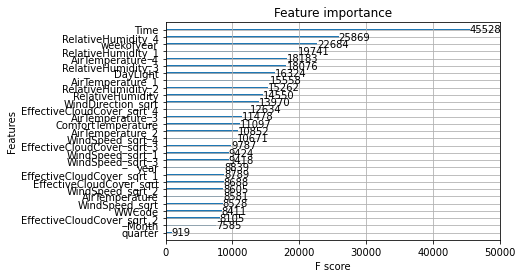

In [ ]:
#xgb_r = XGBRegressor(tree_method="gpu_hist", reg_lambda=0.003549613300028714, reg_alpha=2.081089017939579, colsample_bytree=1.0, subsample=1.0,  learning_rate=0.018, n_estimators=3000,  max_depth=20, random_state=42, min_child_weight=60, silent=0,  gpu_id=0, objective="reg:squarederror") # 22.67
#xgb_r = XGBRegressor(tree_method="gpu_hist", reg_lambda=0.0010803230579963124, reg_alpha=0.8715438364372887, colsample_bytree=1.0, subsample=0.6,  learning_rate=0.02, n_estimators=3000,  max_depth=15, random_state=42, min_child_weight=41, silent=0,  gpu_id=0, objective="reg:squarederror") # 14.91 and 2.96
#xgb_r = XGBRegressor(tree_method="gpu_hist", reg_lambda=0.007613589435623088, reg_alpha=9.409314245606476, colsample_bytree=1.0, subsample=0.6,  learning_rate=0.02, n_estimators=2000,  max_depth=15, random_state=42, min_child_weight=19, silent=0,  gpu_id=0, objective="reg:squarederror") # 14.84 and 2.07
xgb_r = XGBRegressor(tree_method="gpu_hist", reg_lambda=1030.5481517107442, reg_alpha=0.004849068481918107, colsample_bytree=0.763591010113362, subsample=0.9840143076348491,  learning_rate=0.09230294996399775, n_estimators=1811,  max_depth=24, random_state=42, min_child_weight=57, silent=0,  gpu_id=0, objective="reg:squarederror") 
xgb_r.fit(data, target)
xgb.plot_importance(xgb_r,max_num_features=30)

# Submission

In [ ]:
submission = pd.read_csv(root + "sample_submission.csv")

In [ ]:
X_test = features_df.iloc[25560:,:]

In [ ]:
pred = xgb_r.predict(X_test)

In [ ]:
submission["Generation"] = pred

In [ ]:
submission["Generation"] = submission["Generation"].apply(lambda x: 0 if x<5 else x)

In [ ]:
submission

,DateTime,Generation
0,01Dec2021 0:00:00,0.0
1,01Dec2021 1:00:00,0.0
2,01Dec2021 2:00:00,0.0
3,01Dec2021 3:00:00,0.0
4,01Dec2021 4:00:00,0.0
...,...,...
739,31Dec2021 19:00:00,0.0
740,31Dec2021 20:00:00,0.0
741,31Dec2021 21:00:00,0.0
742,31Dec2021 22:00:00,0.0


In [ ]:
submission.to_csv(root+'Son1.csv', index = False)